# Практика №4

Теперь мы построим и обучим простую end-to-end модель. Будем работать с пропатченной версией уже готового [пайплайна](https://www.assemblyai.com/blog/end-to-end-speech-recognition-pytorch). Также нам пригодится [ESPnet](https://github.com/espnet/espnet) для использования модели [Transformer](http://jalammar.github.io/illustrated-transformer/) в качестве энкодера.

### Bootstrap

In [ ]:
!pip install torchaudio

In [2]:
# !gdown --id '1skrVbNyrhBLeceGS9CV9uIw_gvo1JiA6'

№!unzip -q lab4.zip
!rm -rf lab4.zip sample_data
%cd lab4

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1skrVbNyrhBLeceGS9CV9uIw_gvo1JiA6
To: /content/lab4.zip
100% 2.77M/2.77M [00:00<00:00, 214MB/s]
/content/lab4


In [3]:
import os
import torch
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import torchaudio
import numpy as np
import math

from utils import TextTransform
from utils import cer
from utils import wer

from espnet.nets.pytorch_backend.transformer.embedding import PositionalEncoding
from espnet.nets.pytorch_backend.transformer.encoder_layer import EncoderLayer
from espnet.nets.pytorch_backend.transformer.repeat import repeat
from espnet.nets.pytorch_backend.transformer.attention import MultiHeadedAttention
from espnet.nets.pytorch_backend.transformer.positionwise_feed_forward import PositionwiseFeedForward
from espnet.nets.pytorch_backend.transformer.layer_norm import LayerNorm
from espnet.nets.pytorch_backend.nets_utils import make_pad_mask

In [30]:
# !nvidia-smi

In [5]:
train_audio_transforms = torch.nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=400, hop_length=160, n_mels=80),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=30),
    torchaudio.transforms.TimeMasking(time_mask_param=100)
)

valid_audio_transforms = torchaudio.transforms.MelSpectrogram(sample_rate=16000,
                                                              n_fft=400,
                                                              hop_length=160,
                                                              n_mels=80)

text_transform = TextTransform()

#-----------------------------TODO №2-----------------------------------
# Заменить графемный токенайзер на сабвордовый TextTransformBPE
#-----------------------------------------------------------------------


def data_processing(data, data_type="train"):
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    for (waveform, _, utterance, _, _, _) in data:
        if data_type == 'train':
            spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        elif data_type == 'valid':
            spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        else:
            raise Exception('data_type should be train or valid')
        spectrograms.append(spec)
        label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
        labels.append(label)
        input_lengths.append(spec.shape[0])
        label_lengths.append(len(label))

    spectrograms = torch.nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectrograms, labels, input_lengths, label_lengths


def GreedyDecoder(output, labels, label_lengths, blank_label=28, collapse_repeated=True):
    arg_maxes = torch.argmax(output, dim=2)
    decodes = []
    targets = []
    for i, args in enumerate(arg_maxes):
        decode = []
        targets.append(text_transform.int_to_text(labels[i][:label_lengths[i]].tolist()))
        for j, index in enumerate(args):
            if index != blank_label:
                if collapse_repeated and j != 0 and index == args[j -1]:
                    continue
                decode.append(index.item())
        decodes.append(text_transform.int_to_text(decode))
    return decodes, targets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
class TransformerModel(torch.nn.Module):

    def __init__(
        self,
        input_size=80,
        output_size=29,
        conv2d_filters=32,
        attention_dim=240,
        attention_heads=8,
        feedforward_dim=512,
        num_layers=8,
        dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        
        self.conv_in = torch.nn.Sequential(
            torch.nn.Conv2d(1, conv2d_filters, kernel_size=(3,3), stride=(2,2), padding=(1,1)),
            torch.nn.ReLU(),
            torch.nn.Conv2d(conv2d_filters, conv2d_filters, kernel_size=(3,3), stride=(2,2), padding=(1,1)),
            torch.nn.ReLU(),
        )
        self.conv_out = torch.nn.Sequential(
            torch.nn.Linear(conv2d_filters * (input_size // 4), attention_dim),
            PositionalEncoding(attention_dim, 0.1),
        )
        positionwise_layer = PositionwiseFeedForward
        positionwise_layer_args = (attention_dim, feedforward_dim, dropout)
        self.encoder_layer = repeat(
            num_layers,
            lambda lnum: EncoderLayer(
                attention_dim,
                MultiHeadedAttention(
                    attention_heads, attention_dim, dropout
                ),
                positionwise_layer(*positionwise_layer_args),
                dropout,
                normalize_before=True,
                concat_after=False,
            ),
        )
        self.after_norm = LayerNorm(attention_dim)
        self.final_layer = torch.nn.Linear(attention_dim, output_size)

    def forward(self, x, ilens):
        x = x.unsqueeze(1)  # (b, c, t, f)
        x = self.conv_in(x)
        b, c, t, f = x.size()
        x = self.conv_out(x.transpose(1, 2).contiguous().view(b, t, c * f))
        masks = (~make_pad_mask(ilens)[:, None, :])[:, :, ::4].to(x.device)
        x, _ = self.encoder_layer(x, masks)
        x = self.after_norm(x)
        x = self.final_layer(x)
        return x

In [ ]:
x = torch.rand(2, 800, 80)
model = TransformerModel()
output = model(x, [800, 90])
print(output.shape)

torch.Size([2, 200, 29])


In [ ]:
def train(model, device, train_loader, criterion, optimizer, scheduler, epoch):
    model.train()
    data_len = len(train_loader.dataset)
    thresh = len(train_loader) // 4
    for batch_idx, _data in enumerate(train_loader):
        spectrograms, labels, input_lengths, label_lengths = _data 
        spectrograms, labels = spectrograms[:, :, :,:max(input_lengths)].to(device), labels.to(device) #(batch, 1, feat_dim, time)
        spectrograms = spectrograms.squeeze(1).transpose(1,2) # (batch, time, feat_dim,)
        optimizer.zero_grad()
        
        output = model(spectrograms, input_lengths)  # (batch, time, n_classes)
        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1) # (time, batch, n_class)
        input_lengths = [x // 4 for x in input_lengths]

        loss = criterion(output, labels, input_lengths, label_lengths)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        scheduler.step()
        if batch_idx % thresh == 0 or batch_idx == data_len:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tLR: {:.6f}'.format(
                epoch,
                batch_idx * len(spectrograms),
                data_len,
                100. * batch_idx / len(train_loader),
                loss.item(),
                scheduler.get_last_lr()[0]))


def test(model, device, test_loader, criterion, epoch, decode=True):
    print('\nevaluating...')
    model.eval()
    test_loss = 0
    test_cer, test_wer = [], []
    with torch.no_grad():
        for i, _data in enumerate(test_loader):
            spectrograms, labels, input_lengths, label_lengths = _data 
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            spectrograms = spectrograms.squeeze(1).transpose(1,2) # (batch time, feat_dim,)
            
            output = model(spectrograms, input_lengths)  # (batch, time, n_class)
            output = F.log_softmax(output, dim=2)
            output = output.transpose(0, 1) # (time, batch, n_class)
            input_lengths = [x // 4 for x in input_lengths]

            loss = criterion(output, labels, input_lengths, label_lengths)
            test_loss += loss.item() / len(test_loader)

            if decode:
                decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)
                for j in range(len(decoded_preds)):
                    test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                    test_wer.append(wer(decoded_targets[j], decoded_preds[j]))
    if decode:
        avg_cer = sum(test_cer)/len(test_cer)
        avg_wer = sum(test_wer)/len(test_wer)

        print(f"Test set: Average loss: {test_loss:.4f}, Average CER: {avg_cer:4f} Average WER: {avg_wer:.4f}\n")
    else:
        print(f"Average loss: {test_loss:.4f}\n")

In [8]:
def main(output_size = 29, 
         attention_dim = 320,
         feedforward_dim = 1024,
         dropout = 0.1,
         conv2d_filters = 32,
         learning_rate=1e-5, 
         batch_size=20, 
         test_batch_size=7, 
         epochs=10,
         train_url="train-clean-100", 
         test_url="test-clean"):
    
    hparams = {
        "input_size": 80,
        "output_size": output_size,
        "conv2d_filters": conv2d_filters,
        "attention_dim": attention_dim,
        "attention_heads": 8,
        "feedforward_dim": feedforward_dim,
        "num_layers": 10,
        "dropout": dropout,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "epochs": epochs
    }

    use_cuda = torch.cuda.is_available()
    torch.manual_seed(7)
    device = torch.device("cuda" if use_cuda else "cpu")

    if not os.path.isdir("./data"):
        os.makedirs("./data")

    train_dataset = torchaudio.datasets.LIBRISPEECH("./data", url=train_url, download=True)
    test_dataset = torchaudio.datasets.LIBRISPEECH("./data", url=test_url, download=True)

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = data.DataLoader(dataset=train_dataset,
                                batch_size=hparams['batch_size'],
                                shuffle=True,
                                collate_fn=lambda x: data_processing(x, 'train'),
                                **kwargs)
    test_loader = data.DataLoader(dataset=test_dataset,
                                batch_size=test_batch_size,
                                shuffle=False,
                                collate_fn=lambda x: data_processing(x, 'valid'),
                                **kwargs)

    model = TransformerModel(
        hparams['input_size'],
        hparams['output_size'],
        hparams['conv2d_filters'],
        hparams['attention_dim'],
        hparams['attention_heads'],
        hparams['feedforward_dim'],
        hparams['num_layers'],
        hparams['dropout']).to(device)

    print(model)
    print('Num Model Parameters', sum([param.nelement() for param in model.parameters()]))

    optimizer = optim.AdamW(model.parameters(), hparams['learning_rate'])
    criterion = torch.nn.CTCLoss(blank=28, zero_infinity=False).to(device)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=hparams['learning_rate'], 
                                            steps_per_epoch=int(len(train_loader)),
                                            epochs=hparams['epochs'],
                                            anneal_strategy='linear')
    
    for epoch in range(1, epochs + 1):
        !date
        train(model, device, train_loader, criterion, optimizer, scheduler, epoch)
        test(model, device, test_loader, criterion, epoch)

In [ ]:
output_size = 29
attention_dim = 320
feedforward_dim = 1024
dropout = 0.1
conv2d_filters = 32
learning_rate = 1e-3
batch_size = 10
test_batch_size = 7
epochs = 10
libri_train_set = "train-clean-100"
libri_test_set = "test-clean"

main(output_size, attention_dim, feedforward_dim, dropout, 
     conv2d_filters, learning_rate, batch_size, 
     test_batch_size, epochs, libri_train_set, libri_test_set)

In [35]:
### Так как обучение занимает слишком долго времени, прикрепляю скрины из журнала обучения
### Обучение производилось на kaggle

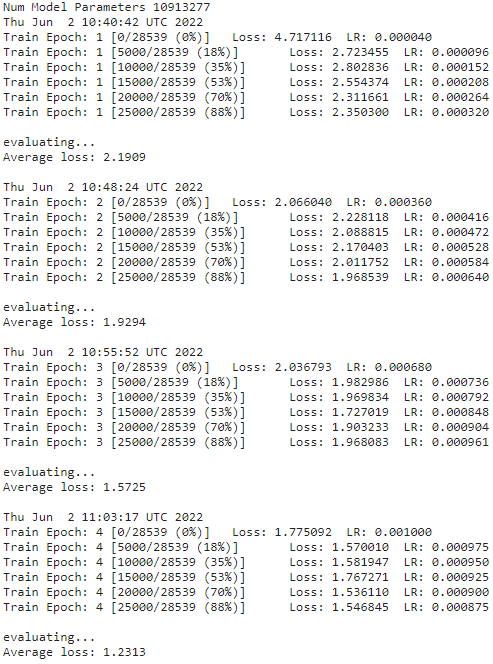

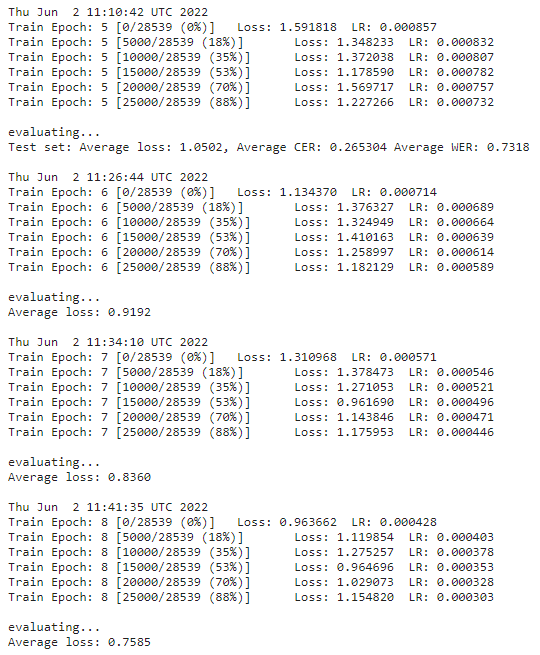

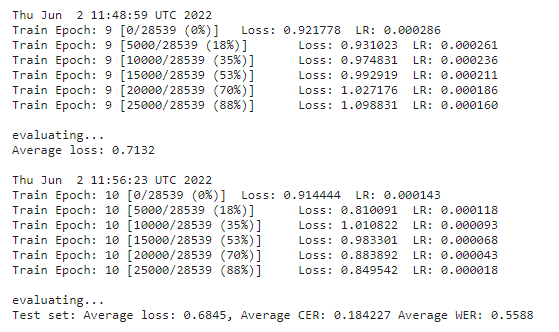

In [4]:
from IPython.display import Image, display
display(Image(filename='images/res_mod_1_1.PNG', embed=True, width = 600))
display(Image(filename='images/res_mod_1_2.PNG', embed=True, width = 600))
display(Image(filename='images/res_mod_1_3.PNG', embed=True, width = 600))

### <b>Задание №1</b> (5 баллов):
На данный момент практически все E2E SOTA решения используют [сабворды](https://dyakonov.org/2019/11/29/%D1%82%D0%BE%D0%BA%D0%B5%D0%BD%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F-%D0%BD%D0%B0-%D0%BF%D0%BE%D0%B4%D1%81%D0%BB%D0%BE%D0%B2%D0%B0-subword-tokenization/) (subwords/wordpieces) в качестве таргетов нейронки для распознавания. Нам бы тоже не мешало перейти от графем к сабвордам. Теперь вместо букв (графем) будем распознавать кусочки слов. В качестве такого токенайзера предлагается использовать [Sentencepiece](https://github.com/google/sentencepiece). Пример обучения BPE токенайзера можно найти в [link](https://github.com/google/sentencepiece/tree/master/python). Главное правильно обернуть его в наш класс TextTransformBPE. Текстовый файл (train_clean_100_text_clean.txt) для обучения токенайзера уже подготовлен и лежит в корневой папке проекта. 

In [5]:
class TextTransformBPE:
    def __init__(self, train_text):
        """ Обучение BPE модели на 2000 юнитов"""
        spm.SentencePieceTrainer.train(
            input=train_text, model_prefix='m', vocab_size=2000,
            normalization_rule_name='nfkc_cf', model_type='bpe',
        )
        self.model = spm.SentencePieceProcessor(model_file='m.model')

    def text_to_int(self, text):
        """ Преобразование входного текста в последовательность сабвордов в формате их индекса в BPE модели """
        int_sequence = self.model.encode(text)
        return int_sequence

    def int_to_text(self, labels):
        """ Преобразование последовательности индексов сабвордов в текст """
        string = self.model.decode(list(map(int, labels)))
        return string

### **Ответ**:
...

In [ ]:
# Берем ту же модель только с BPE. Значение WER уменьшается более чем на 7%

In [ ]:
text_transform = TextTransformBPE(train_text='train_clean_100_text_clean.txt')

output_size = 2001 #!!!
attention_dim = 320
feedforward_dim = 1024
dropout = 0.1
conv2d_filters = 32
learning_rate = 1e-3
batch_size = 10
test_batch_size = 7
epochs = 10
libri_train_set ="train-clean-100"
libri_test_set = "test-clean"

main(output_size, attention_dim, feedforward_dim, dropout, conv2d_filters,
     learning_rate, batch_size, test_batch_size, epochs, libri_train_set, libri_test_set)

In [ ]:
# скрины из журнала обучения

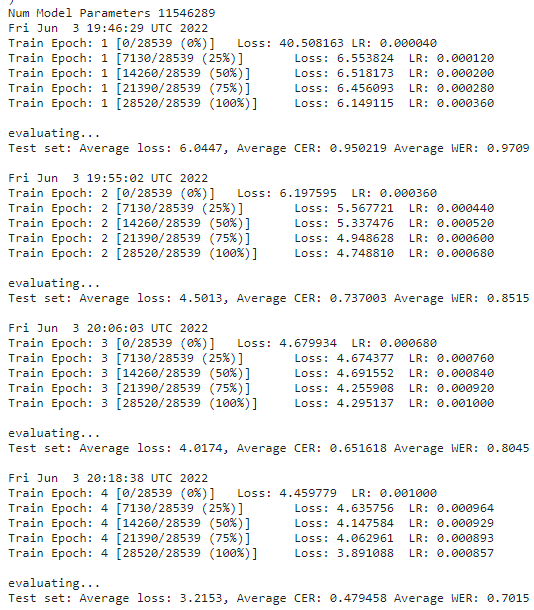

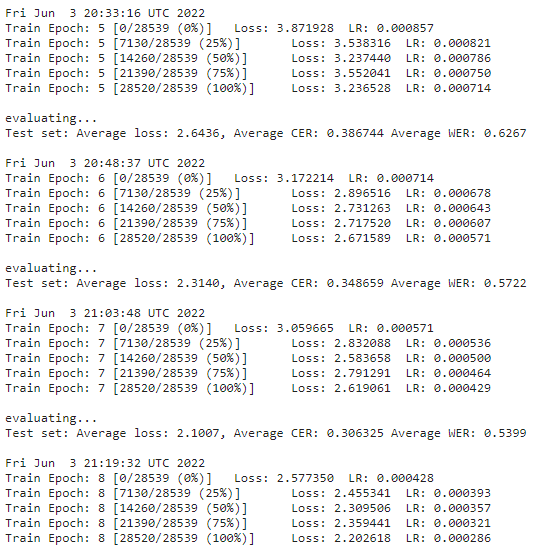

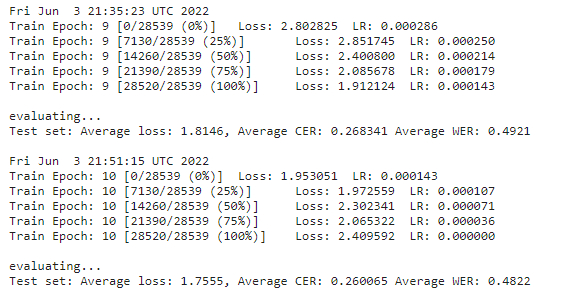

In [5]:
display(Image(filename='images/res_mod_2_1.PNG', embed=True, width = 600))
display(Image(filename='images/res_mod_2_2.PNG', embed=True, width = 600))
display(Image(filename='images/res_mod_2_3.PNG', embed=True, width = 600))

### <b>Задание №2</b> (5 баллов):
Импровизация по улучшению качества распознавания.

### **Ответ**:
...

In [22]:
# Уменьшим размерность attention_dim с 320 до 256 и увеличим learning_rate в два раза
# В этом случае значение WER уменьшается по сравнению с предыдущим случаем на 5%

In [ ]:
text_transform = TextTransformBPE(train_text='train_clean_100_text_clean.txt')

output_size = 2001
attention_dim = 256   
feedforward_dim = 1024 
dropout = 0.1
conv2d_filters = 32
learning_rate = 0.002
batch_size = 15
test_batch_size = 7
epochs = 10
libri_train_set ="train-clean-100"
libri_test_set = "test-clean"

main(output_size, attention_dim, feedforward_dim, dropout, conv2d_filters,
     learning_rate, batch_size, test_batch_size, epochs, libri_train_set, libri_test_set)

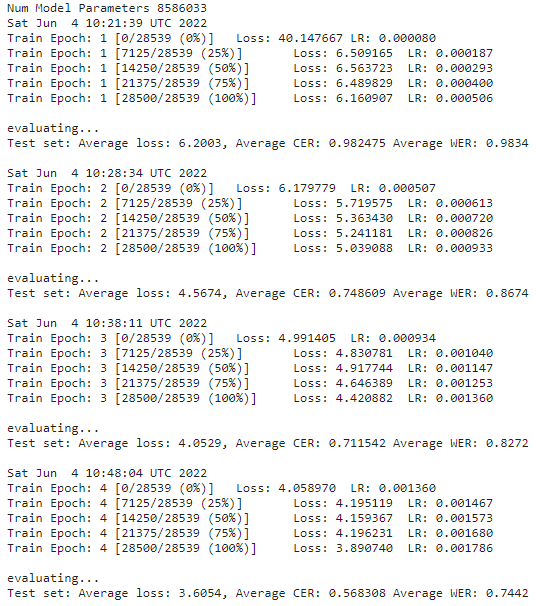

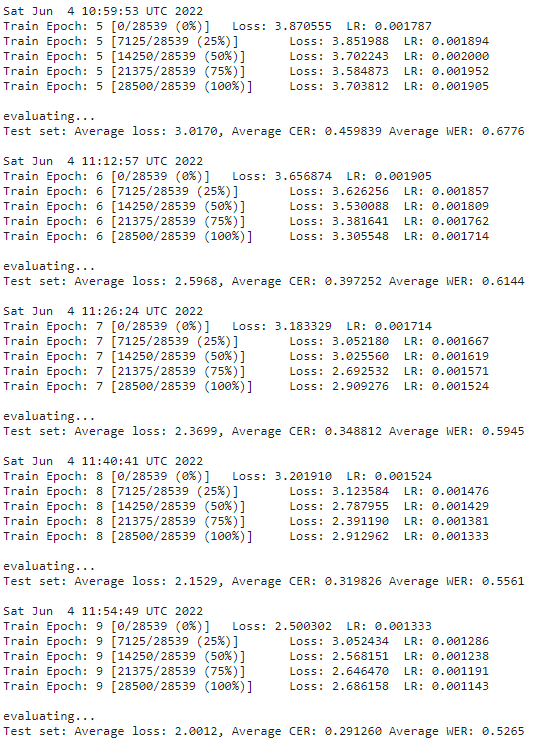

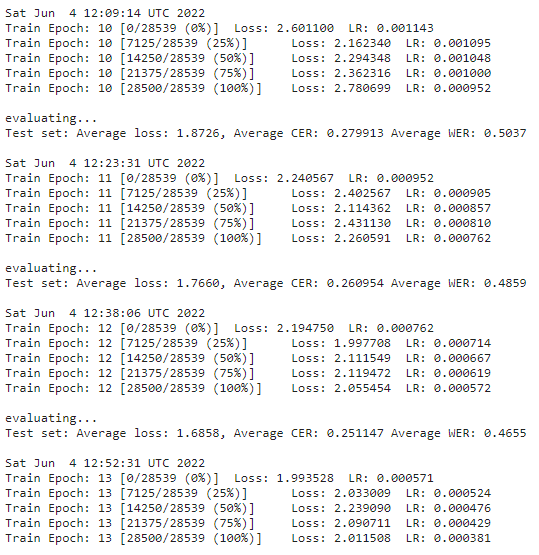

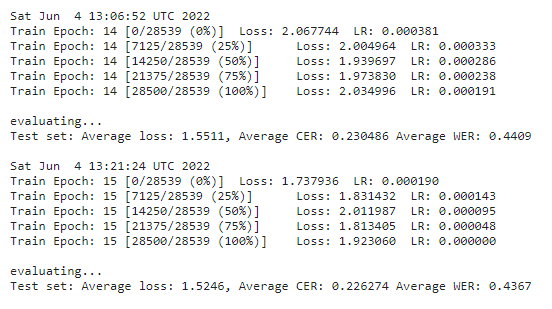

In [6]:

display(Image(filename='images/res_mod_3_1.PNG', embed=True, width = 600))
display(Image(filename='images/res_mod_3_2.PNG', embed=True, width = 600))
display(Image(filename='images/res_mod_3_3.PNG', embed=True, width = 600))
display(Image(filename='images/res_mod_3_4.PNG', embed=True, width = 600))

In [ ]:
# Увеличим размерность attention_dim с 256 до 512 и уменьшим learning_rate в два раза по 
# Значение WER уменьшается еще на 5%

In [ ]:

text_transform = TextTransformBPE(train_text='train_clean_100_text_clean.txt')

output_size = 2001
attention_dim = 512       
feedforward_dim = 1024    
dropout = 0.1             
conv2d_filters = 32
learning_rate = 1e-3
batch_size = 15
test_batch_size = 7
epochs = 10
libri_train_set ="train-clean-100"
libri_test_set = "test-clean"

main(output_size, attention_dim, feedforward_dim, dropout, learning_rate, 
     batch_size, test_batch_size, epochs, libri_train_set, libri_test_set)

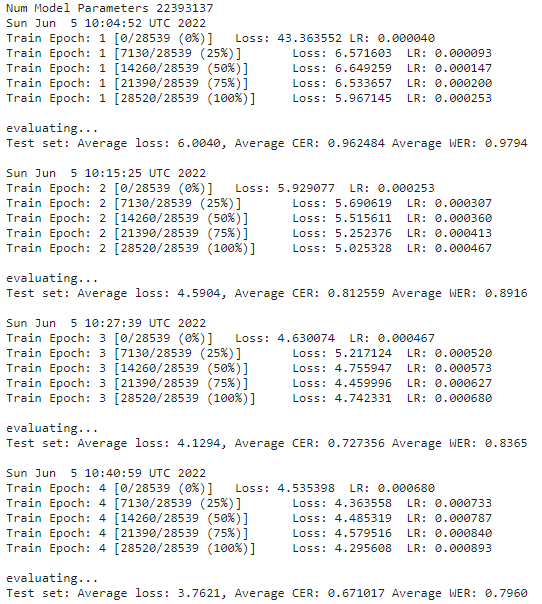

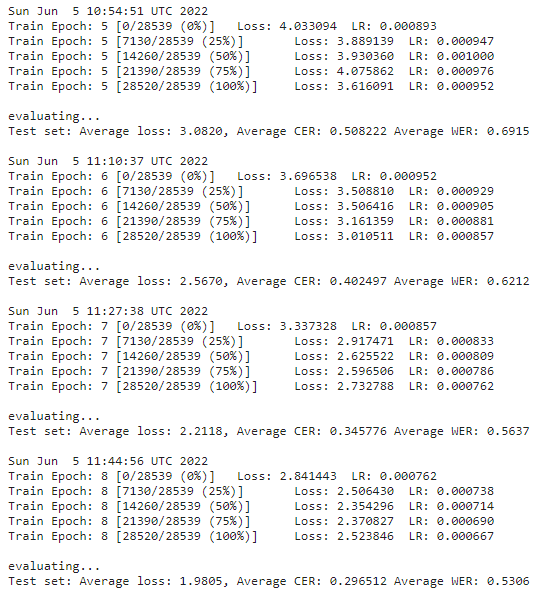

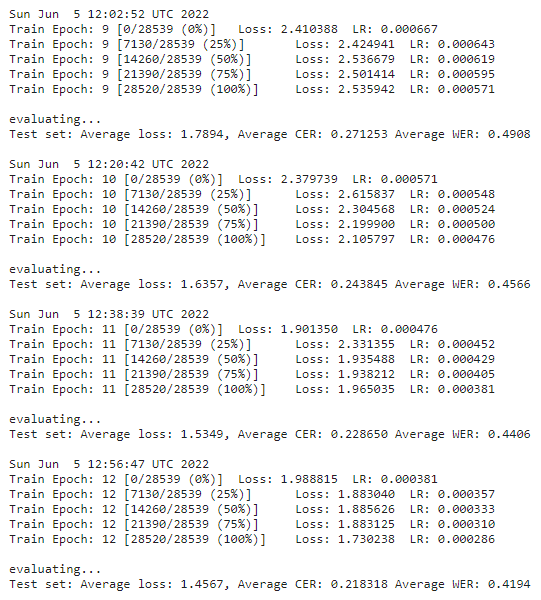

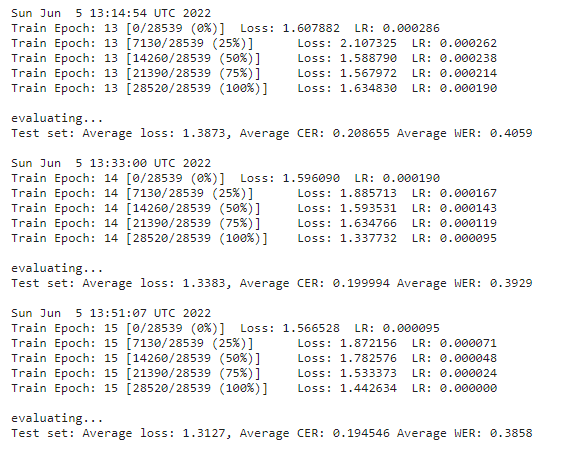

In [7]:
display(Image(filename='images/res_mod_4_1.PNG', embed=True, width = 600))
display(Image(filename='images/res_mod_4_2.PNG', embed=True, width = 600))
display(Image(filename='images/res_mod_4_3.PNG', embed=True, width = 600))
display(Image(filename='images/res_mod_4_4.PNG', embed=True, width = 600))

In [ ]:
# Были еще попытки достичь улучшения качества модели через изменение размерности  feedforward_dim,
# величины dropout и learning_rate. Но в целом, такие манипуляции не привели к заметному
# улучшению скора.